# Stock Market Sentiment Analysis and Price Prediction 💹

### Importing modules

In [36]:
# Matrix math and DataFrames
import numpy as np
import pandas as pd

# Scaling
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler( feature_range = (-1,1))
y_scaler = MinMaxScaler( feature_range = (-1,1))

# Plotting
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# Keras model and LSTM
from keras.models import Sequential
from keras.layers import LSTM,Dense

In [37]:
# plotly offline config
py.offline.init_notebook_mode(connected=True)

## Retriving, Slicing and Dicing
Choosing the Facebook stock

### Use to fetch data from quandl
```python
import quandl as ql
ql.ApiConfig.api_key = "b6y7-mew_t8z5yGJijFv"
data = ql.get("WIKI/fb")
data.to_csv("Facebook", encoding='utf-8')
```

### Use the following code to generate Facebook_Sentiments.csv with sentiments

```python
from txtanalysis import *
tw = TweetSentiments()
sentiment_data = pd.DataFrame(index=range( df.shape[0]),\
                                          columns=['Sentiments'])
for i in range( train_limit):
    try :
        sentiment_data['Sentiments'][i] = tw.get_input( '@facebook'\
                                                      , df['Date'][i])
    except tweepy.TweepError:
        time.sleep(60 * 15)
        continue
    except StopIteration:
        break
df[:5]
sentiment_data.to_csv( 'Facebook_Sentiments', encoding='utf-8')
df.join( sentiment_data)
```

In [38]:
df = pd.read_csv("Facebook")[['Date','Open','Close','High','Low']]
train_limit = round(df.shape[0]*0.8)
print(train_limit)
df[:5]

1178


,Date,Open,Close,High,Low
0,2012-05-18,42.05,38.2318,45.00,38.00
1,2012-05-21,36.53,34.0300,36.66,33.00
2,2012-05-22,32.61,31.0000,33.59,30.94
3,2012-05-23,31.37,32.0000,32.50,31.36
4,2012-05-24,32.95,33.0300,33.21,31.77


## Plotting as a TimeSeries

In [39]:
trace_high = go.Scatter(
    x=df['Date'],
    y=df['High'],
    name = "High",
#     line = dict(color = '#17BECF'),
    opacity = 0.9)

trace_low = go.Scatter(
    x=df['Date'],
    y=df['Low'],
    name = "Low",
#     line = dict(color = '#7F7F7F'),
    opacity = 0.8)

trace_open = go.Scatter(
    x=df['Date'],
    y=df['Open'],
    name = "Open",
#     line = dict(color = '#17BECF'),
    opacity = 0.9)

trace_close = go.Scatter(
    x=df['Date'],
    y=df['Close'],
    name = "Close",
#     line = dict(color = '#7F7F7F'),
    opacity = 0.8)

plot_data = [ trace_high, trace_low, trace_open, trace_close]

layout = go.Layout(
    title='Facebook',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Prices',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = dict(data=plot_data, layout=layout)
py.offline.iplot(fig, filename = "Facebook Plot")

# Data transformation

## Scaling
Warning! DataFrames will be changed after this...

In [40]:
df = pd.read_csv('Facebook_Sentiments')
df = df[['Open','Close','High','Low','Sentiments']]
df[['Open','High','Low','Sentiments']] = X_scaler.fit_transform(df[['Open','High','Low','Sentiments']])
df[['Close']] = y_scaler.fit_transform(df[['Close']])

## Splitting into train, validate and test sets

In [41]:
sequence_len = 20 # choose sequence length

train_data = pd.DataFrame( columns = ['Open','Close','High','Low','Sentiments'])
valid_limit = train_limit + round(df.shape[0]*0.1)
test_limit = -1*round(df.shape[0]*0.1)

# create all possible sequences of length sequence_len
validate_data = df[train_limit: valid_limit]
test_data = df[ test_limit :-1 ]

df = df[:train_limit]

for index in range( train_limit - sequence_len):
    train_data = train_data.append( df[index: index + sequence_len])

print( train_data[:5], validate_data[-5:-1] ,test_data[:5])

# no_sequences_train = int(train_data.shape[0]/sequence_len)
# no_sequences_valid = int(validate_data.shape[0]/sequence_len)
# no_sequences_test = int(test_data.shape[0]/sequence_len)

X_train = train_data[['Open','High','Low','Sentiments']].as_matrix().reshape( train_data.shape[0], 1, 4)
y_train = train_data[['Close']].as_matrix().flatten()

X_valid = validate_data[['Open','High','Low','Sentiments']].as_matrix().reshape( validate_data.shape[0], 1, 4)
y_valid = validate_data[['Close']].as_matrix().flatten()
# .reshape( 1, validate_data.shape[0], 1)

X_test = test_data[['Open','High','Low','Sentiments']].as_matrix().reshape( test_data.shape[0], 1, 4)
y_test = test_data[['Close']].as_matrix().flatten()
# .reshape( 1, test_data.shape[0], 1)
print(X_train.shape, y_train.shape)

# y_train = np.hstack(np.asarray(df.output_vector)).reshape(len(df), 1)

       Open     Close      High       Low  Sentiments
0 -0.724419 -0.766165 -0.698051 -0.762802    0.173529
1 -0.787882 -0.814086 -0.792262 -0.820797    0.047549
2 -0.832950 -0.848644 -0.826942 -0.844691   -0.146465
3 -0.847206 -0.837239 -0.839254 -0.839819    0.267974
4 -0.829041 -0.825491 -0.831234 -0.835064    0.235294           Open     Close      High       Low  Sentiments
1320  0.739020  0.701416  0.712398  0.731717    0.038429
1321  0.710278  0.707118  0.698955  0.724294   -0.002748
1322  0.713957  0.711338  0.691387  0.719770    0.066176
1323  0.726834  0.732552  0.712511  0.735197    0.228848           Open     Close      High       Low  Sentiments
1325  0.733732  0.710882  0.705959  0.726614    0.324955
1326  0.722005  0.694687  0.695679  0.723946    0.035762
1327  0.711083  0.705180  0.687998  0.725686    0.151738
1328  0.691998  0.714418  0.696188  0.710259    0.108957
1329  0.725569  0.735745  0.716012  0.740764    0.126931
(23160, 1, 4) (23160,)


## LSTM

In [7]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=( 1, 4)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Fit model with history to check for overfitting
history = model.fit( X_train, y_train, epochs=20, validation_data=(X_valid,y_valid), shuffle=True)

Train on 23160 samples, validate on 147 samples
Epoch 1/20
23160/23160 [==============================] - 13s 557us/step - loss: 0.0070 - val_loss: 3.2994e-04
Epoch 2/20
23160/23160 [==============================] - 10s 425us/step - loss: 8.2657e-05 - val_loss: 1.5930e-04
Epoch 3/20
23160/23160 [==============================] - 10s 447us/step - loss: 8.1610e-05 - val_loss: 1.3734e-04
Epoch 4/20
23160/23160 [==============================] - 11s 488us/step - loss: 8.0969e-05 - val_loss: 1.9103e-04
Epoch 5/20
23160/23160 [==============================] - 11s 488us/step - loss: 8.0566e-05 - val_loss: 1.3032e-04
Epoch 6/20
23160/23160 [==============================] - 11s 495us/step - loss: 7.7282e-05 - val_loss: 1.1836e-04

> Training observations
* Overfitting occurs at approx. 20 epochs
* 1e-5 to 9e-5 validation loss with shuffle
* . to . validation loss without shuffle

## Validation data vs Predicted data
Red -> Real

Green -> Predicted

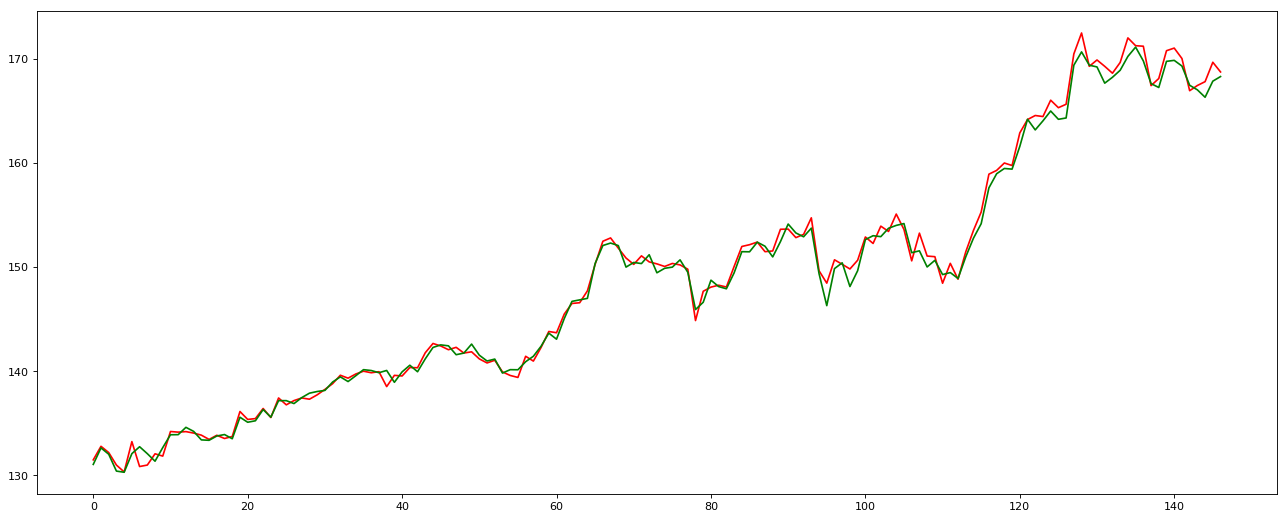

In [45]:
predicted = model.predict(X_valid)
real = list(y_scaler.inverse_transform(y_valid.reshape(-1,1)))
predicted = list(y_scaler.inverse_transform(predicted.reshape(-1,1)))

plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(real, color = 'r' )
plt.plot(predicted, color = 'g')

## Test data vs Predicted data
Red -> Real

Green -> Predicted

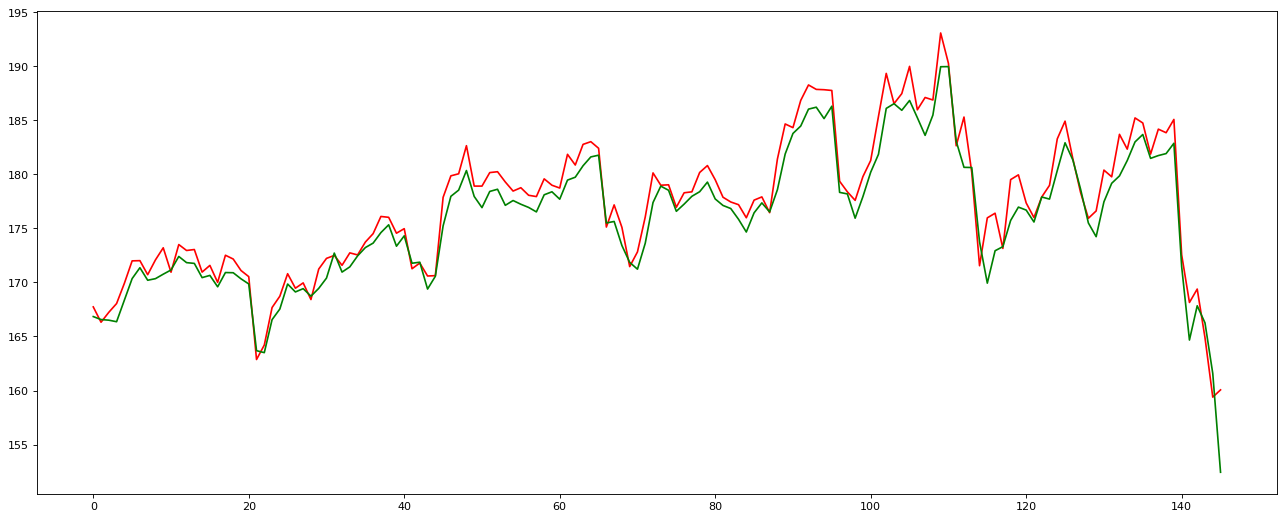

In [46]:
predicted = model.predict(X_test)
real = list(y_scaler.inverse_transform(y_test.reshape(-1,1)))
predicted = list(y_scaler.inverse_transform(predicted.reshape(-1,1)))

plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(real, color = 'r' )
plt.plot(predicted, color = 'g')